In [54]:
import time
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import networkx as nx

In [57]:
if torch.cuda.is_available():
    print("CUDA (GPU support) is available in PyTorch!")
else:
    print("CUDA (GPU support) is not available in PyTorch.")

CUDA (GPU support) is available in PyTorch!


In [2]:
# Set seeds for reproducibility
torch.manual_seed(177013)
np.random.seed(177013)


In [24]:
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        self.tanh = nn.Tanh()

    def forward(self, x):
        for layer in self.hidden_layers[:-1]:
            x = self.tanh(layer(x))
        x = self.hidden_layers[-1](x)  # No activation after the last layer
        return x
    
    def model_forward(self, x):
        x.requires_grad = True
        p = self.forward(x)
        p_x = torch.autograd.grad(p, x, torch.ones_like(p), create_graph=True, retain_graph=True)[0]
        k_x_p_x = self.k(x, p) * p_x
        k_x_p_x_X = torch.autograd.grad(k_x_p_x, x, torch.ones_like(k_x_p_x), create_graph=True)[0]
        return p, k_x_p_x_X

    def f(self, x):
        return -torch.ones_like(x)

    def k(self, x, p):
        return 1 + x * p

    def loss_fn(self, p, x):
        eq = -self.f(x) - self.k(x, p)
        bc_loss = torch.mean(p[0] ** 2) + torch.mean(p[-1] ** 2)
        return torch.mean(eq ** 2) + bc_loss

In [25]:
# Define the network, training data, and optimizer
layers = [1, 5, 5, 5, 1]  # Include input and output sizes
model = PINN(layers)
x_train = torch.linspace(0, 1, 100).view(-1, 1)  # unflatten each value to array
optimizer = optim.Adam(model.parameters(), lr=0.005)

n_epochs = 1000
loss_array = []
best_epoch = 0
best_loss = float('inf')

In [27]:
start_time = time.time()
loss = torch.tensor(1)
epoch = 0
while loss.item() > math.pow(0.1, 3) and epoch < n_epochs:
    optimizer.zero_grad()
    p, k_x_p_x = model.model_forward(x_train)
    loss = model.loss_fn(p, x_train)
    loss.backward()
    optimizer.step()

    if loss.item() < best_loss:
        best_epoch = epoch
        best_loss = loss.item()

    loss_array.append(loss.item())
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
    epoch += 1

print("Training took %s seconds" % (time.time() - start_time))
print(f"Best epoch: {best_epoch}, Best loss: {best_loss}")

Epoch 0, Loss: 0.07122576981782913
Training took 0.014925718307495117 seconds
Best epoch: 5, Best loss: 0.000986978760920465


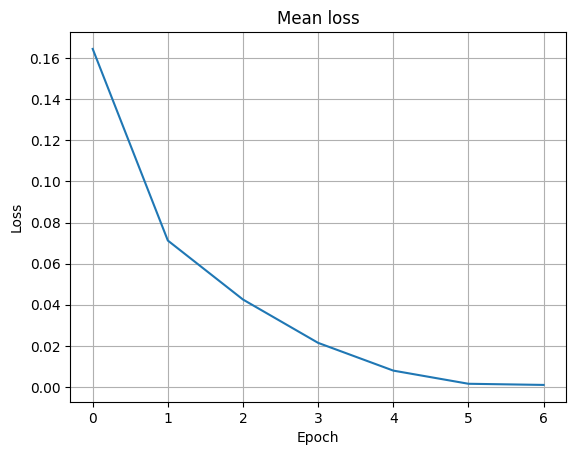

In [28]:
plt.plot(loss_array)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.title('Mean loss')
plt.show()

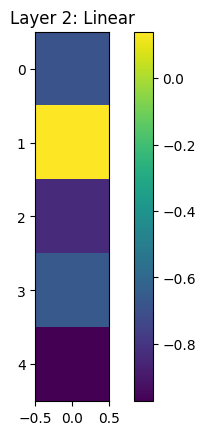

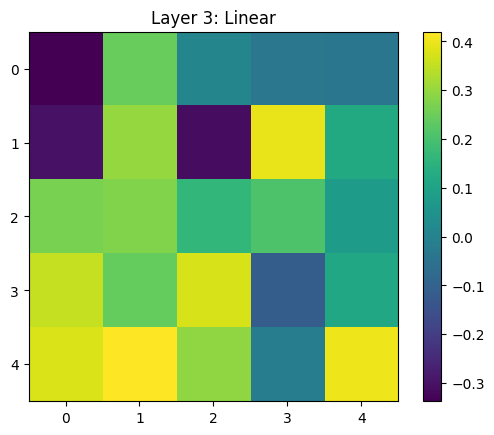

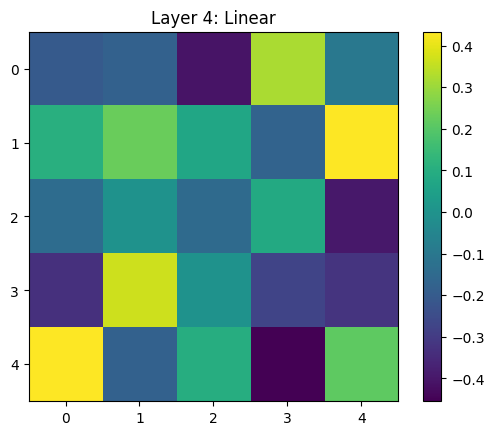

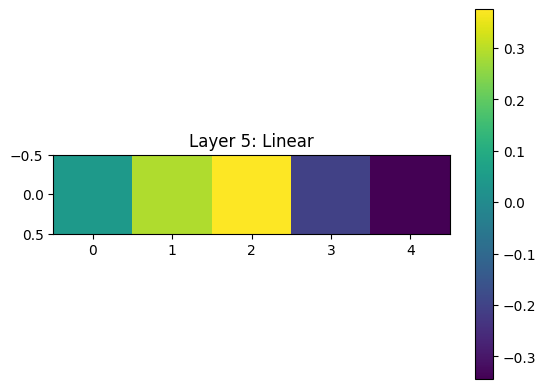

In [40]:
for i, layer in enumerate(model.modules()):
        # Check if the layer has learnable parameters
        if hasattr(layer, 'weight') and hasattr(layer.weight, 'data'):
            w = layer.weight.data.numpy()  # Convert weights to numpy array
            fig, ax = plt.subplots()
            if w.ndim == 2:  # Dense layer
                # Create a heatmap
                cax = ax.imshow(w, cmap="viridis")
                ax.set_title(f"Layer {i}: {type(layer).__name__}")
                fig.colorbar(cax)
            elif w.ndim == 1:  # 1D weights (e.g., embeddings)
                ax.bar(np.arange(len(w)), w)
                ax.set_title(f"Layer {i}: {type(layer).__name__}")
            else:
                print(f"Layer {i} has unsupported weight shape {w.shape}.")
            plt.show()
        else:
            # Skip layers without weights
            continue

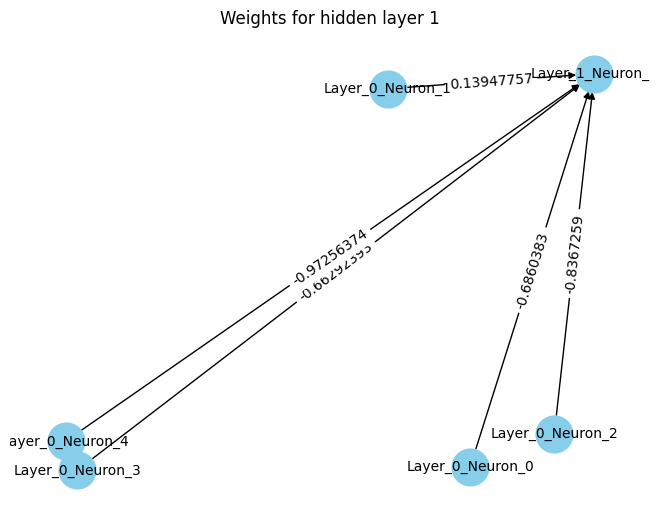

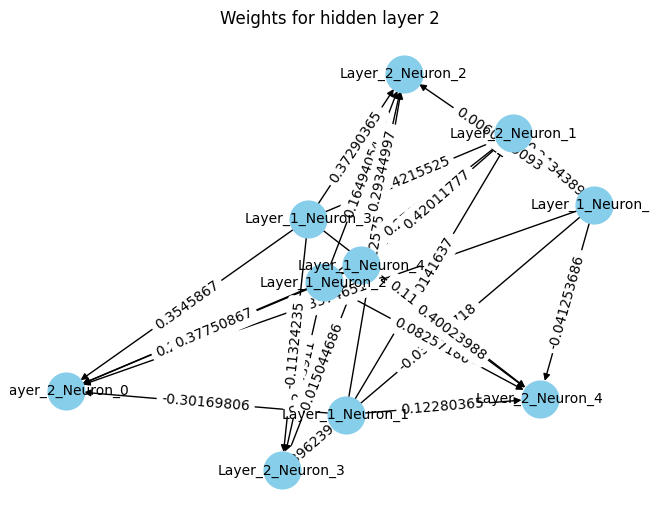

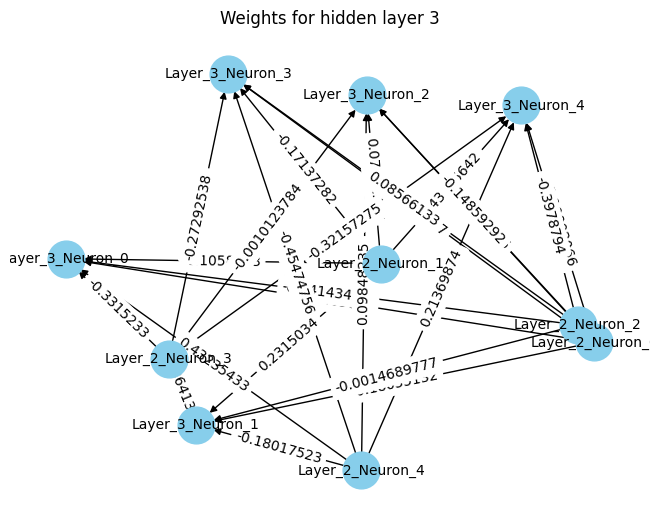

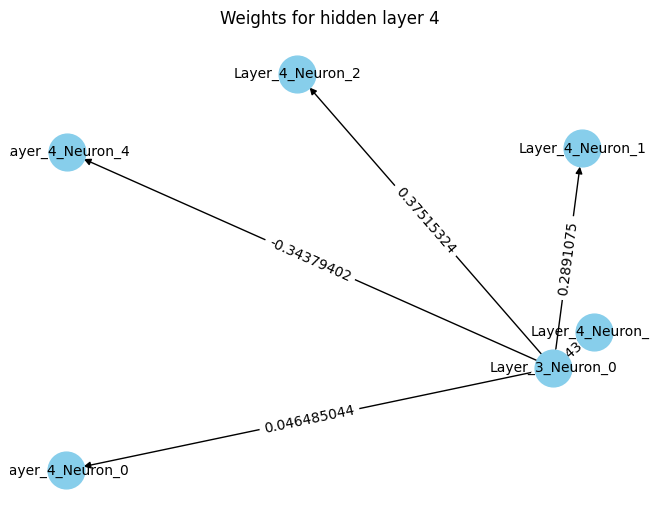

In [55]:
for l, layer in enumerate(model.hidden_layers):  # Assuming model.hidden_layers is defined
        # Ensure the layer has weights (e.g., not an activation layer)
        if hasattr(layer, 'weight'):
            W = layer.weight.data.numpy()  # Convert PyTorch tensor to NumPy array

            G = nx.DiGraph()  # Create a directed graph object

            n_neurons_in = W.shape[0]  # Neurons in the layer (input)
            n_neurons_out = W.shape[1]  # Neurons in the next layer (output)

            # Add nodes
            for i in range(n_neurons_in):
                G.add_node(f"Layer_{l}_Neuron_{i}")

            for j in range(n_neurons_out):
                G.add_node(f"Layer_{l+1}_Neuron_{j}")

            # Add edges with weights
            for i in range(n_neurons_in):
                for j in range(n_neurons_out):
                    weight = W[i, j]
                    G.add_edge(f"Layer_{l}_Neuron_{i}", f"Layer_{l+1}_Neuron_{j}", weight=weight)

            # Draw the graph
            pos = nx.spring_layout(G)  # positions for all nodes
            nx.draw(G, pos, with_labels=True, node_color='skyblue', font_size=10, node_size=700)
            labels = nx.get_edge_attributes(G, 'weight')
            nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

            plt.title(f"Weights for hidden layer {l+1}")
            plt.show()

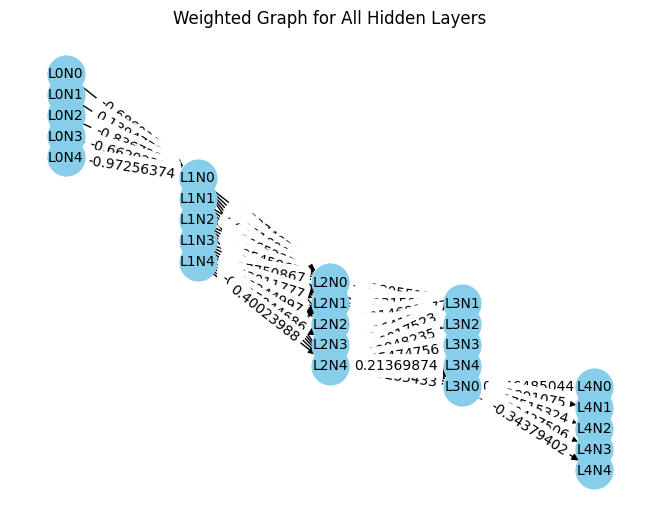

In [56]:
G = nx.DiGraph()  # Create a single directed graph object for all layers
pos = {}  # Dictionary to store the positions of nodes

y_offset = 0  # Initialize y_offset to align nodes

# Loop over hidden layers
for l, layer in enumerate(model.hidden_layers):  # Assuming model.hidden_layers is defined
    if hasattr(layer, 'weight'):
        W = layer.weight.data.numpy()  # Convert weights to numpy array
        
        n_neurons_in = W.shape[0]  # Neurons in this layer (input)
        n_neurons_out = W.shape[1]  # Neurons in the next layer (output)

        # Add nodes and set their positions
        for i in range(n_neurons_in):
            node_name = f"L{l}N{i}"
            G.add_node(node_name)
            pos[node_name] = (l, y_offset - i * 10)  # x is layer index, y is neuron index
            
        for j in range(n_neurons_out):
            node_name = f"L{l+1}N{j}"
            G.add_node(node_name)
            pos[node_name] = (l+1, y_offset - j * 10)  # x is layer index, y is neuron index

        # Adjust y_offset for next layer
        y_offset -= max(n_neurons_in, n_neurons_out) * 10

        # Add edges with weights
        for i in range(n_neurons_in):
            for j in range(n_neurons_out):
                weight = W[i, j]
                G.add_edge(f"L{l}N{i}", f"L{l+1}N{j}", weight=weight)

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='skyblue', font_size=10, node_size=700)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.title("Weighted Graph for All Hidden Layers")
plt.show()